In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('tracks_data.csv')

# Display the first few rows of the dataframe
df.head()

,genre,track_id,track_name,artist_name,tempo,danceability,energy,acousticness,duration_ms,instrumentalness,liveness,loudness,mode,speechiness,time_signature,valence
0,pop,3Dv1eDb0MEgF93GpLXlucZ,Say So,Doja Cat,110.962,0.787,0.673,0.2640,237893,0.000003,0.0904,-4.583,0,0.159,4,0.779
1,pop,7MXVkk9YMctZqd1Srtv4MB,Starboy,The Weeknd,186.003,0.679,0.587,0.1410,230453,0.000006,0.1370,-7.015,1,0.276,4,0.486
2,pop,0t3ZvGKlmYmVsDzBJAXK8C,Goodbyes (feat. Young Thug),Post Malone,150.097,0.547,0.653,0.4560,174853,0.000000,0.1030,-3.875,1,0.081,4,0.163
3,pop,7ytR5pFWmSjzHJIeQkgog4,ROCKSTAR (feat. Roddy Ricch),DaBaby,89.977,0.746,0.690,0.2470,181733,0.000000,0.1010,-7.956,1,0.164,4,0.497
4,pop,6DCZcSspjsKoFjzjrWoCdn,God's Plan,Drake,77.169,0.754,0.449,0.0332,198973,0.000083,0.5520,-9.211,1,0.109,4,0.357


In [2]:
# Check for duplicates and remove them
df = df.drop_duplicates(subset='track_id')

# Shuffle the data
df = df.sample(frac=1, random_state=420).reset_index(drop=True)

# Capture the unique genre labels before encoding
genre_labels = df['genre'].unique()

# Encode the genre as numerical values
df['genre'] = df['genre'].astype('category').cat.codes

# Separate features and target variable
X = df.drop(columns=['genre', 'track_id', 'track_name', 'artist_name'])
y = df['genre']

# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=420)

# ML Models

## Logistic Regression

Best parameters for Logistic Regression: {'C': 1000, 'solver': 'lbfgs'}
Best score for Logistic Regression: 0.6391304347826086
Logistic Regression Accuracy: 0.6069364161849711
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        21
           1       0.67      0.75      0.71        16
           2       0.58      0.79      0.67        14
           3       0.38      0.33      0.35        18
           4       0.86      0.75      0.80        24
           5       0.60      0.47      0.53        19
           6       0.54      0.65      0.59        20
           7       0.47      0.30      0.37        23
           8       0.52      0.61      0.56        18

    accuracy                           0.61       173
   macro avg       0.60      0.61      0.60       173
weighted avg       0.60      0.61      0.60       173



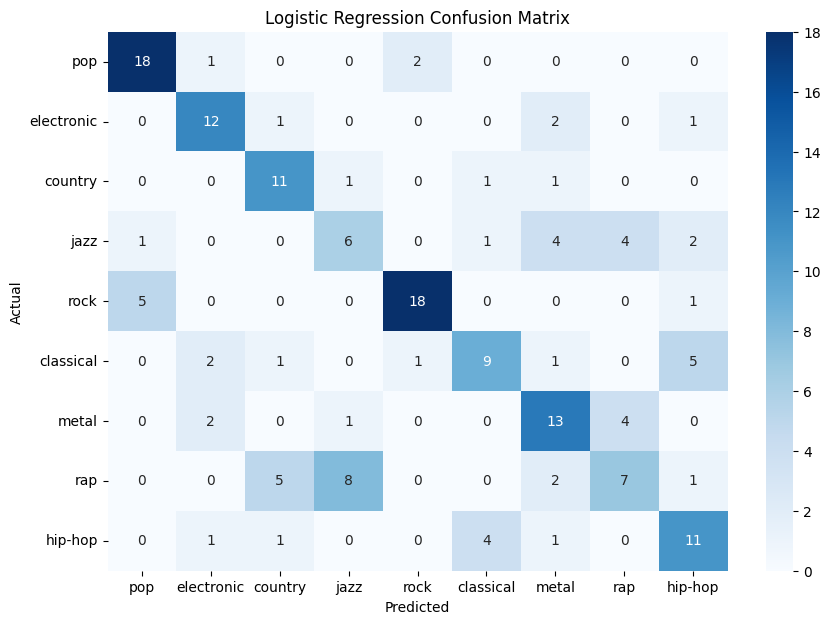

In [4]:
# Create a GridSearchCV parameter library to optimize
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'lbfgs']
}

# Create the GridSearchCV object
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy')
# Fit this model
grid_search_lr.fit(X_train, y_train)

print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best score for Logistic Regression:", grid_search_lr.best_score_)
lrScore = grid_search_lr.best_score_
y_pred_lr = grid_search_lr.best_estimator_.predict(X_test)
lrAccuracy = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Random Forest

Best parameters for Random Forest: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}
Best score for Random Forest: 0.6768115942028985
Random Forest Accuracy: 0.5953757225433526
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.57      0.81      0.67        16
           2       0.56      0.71      0.62        14
           3       0.35      0.39      0.37        18
           4       0.68      0.79      0.73        24
           5       0.64      0.47      0.55        19
           6       0.67      0.60      0.63        20
           7       0.38      0.22      0.28        23
           8       0.61      0.61      0.61        18

    accuracy                           0.60       173
   macro avg       0.58      0.60      0.59       173
weighted avg       0.59      0.60      0.58       173



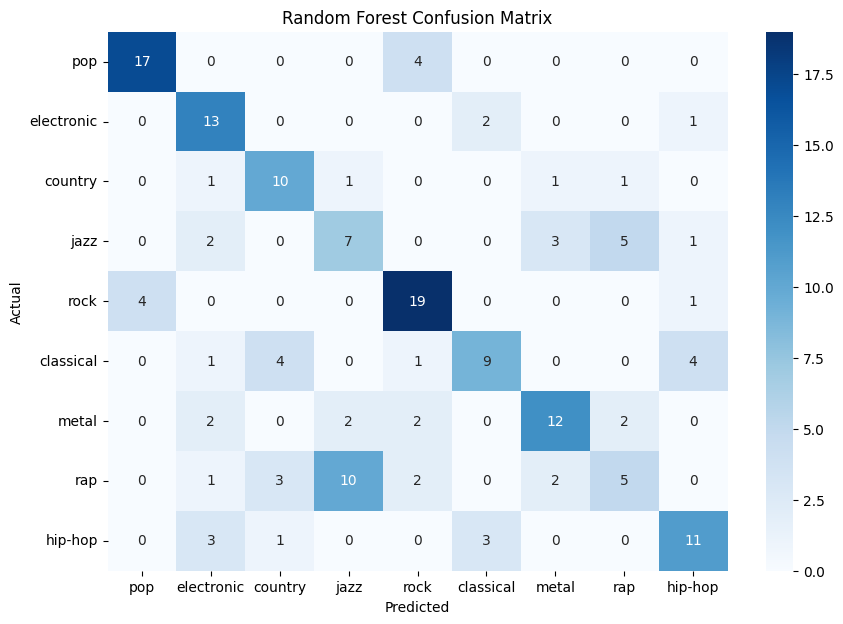

In [5]:
param_grid_rf = {
    'n_estimators': [25, 50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy']
}

# GridSearchCV object
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
# Fit
grid_search_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best score for Random Forest:", grid_search_rf.best_score_)
rfScore = grid_search_rf.best_score_
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)
rfAccuracy = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Support Vector Machine (SVM)

Best parameters for SVM: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best score for SVM: 0.6405797101449275
Random Forest Accuracy: 0.5953757225433526
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.79      0.69      0.73        16
           2       0.56      0.71      0.62        14
           3       0.31      0.28      0.29        18
           4       0.77      0.83      0.80        24
           5       0.58      0.37      0.45        19
           6       0.46      0.65      0.54        20
           7       0.47      0.30      0.37        23
           8       0.57      0.72      0.63        18

    accuracy                           0.60       173
   macro avg       0.59      0.60      0.58       173
weighted avg       0.59      0.60      0.59       173



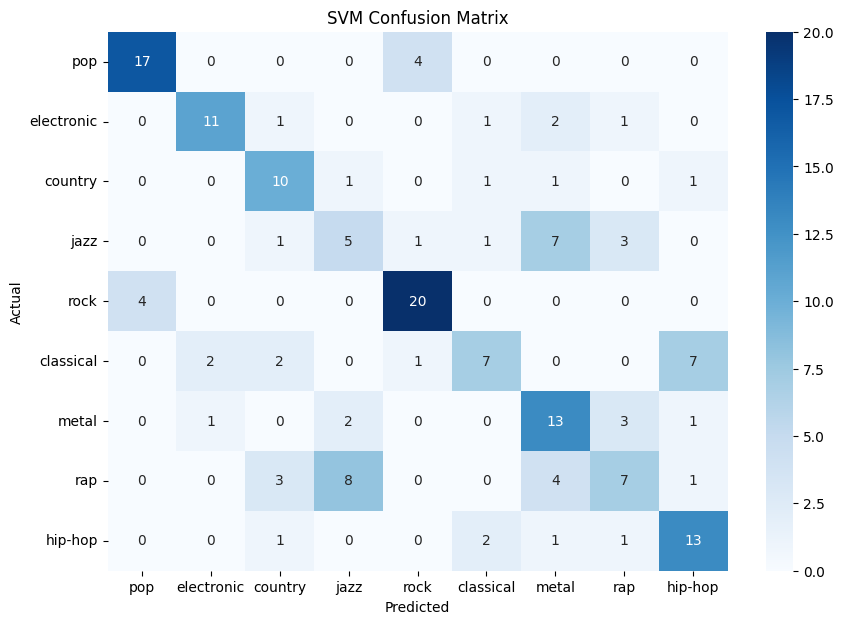

In [6]:
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# GridSearchCV object
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')
# Fit
grid_search_svm.fit(X_train, y_train)

print("Best parameters for SVM:", grid_search_svm.best_params_)
print("Best score for SVM:", grid_search_svm.best_score_)
svmScore = grid_search_svm.best_score_
y_pred_svm = grid_search_svm.best_estimator_.predict(X_test)
svmAccuracy = accuracy_score(y_test, y_pred_svm)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Decision Tree

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best score for Decision Tree: 0.5521739130434783
Decision Tree Accuracy: 0.4624277456647399
              precision    recall  f1-score   support

           0       0.73      0.76      0.74        21
           1       0.58      0.69      0.63        16
           2       0.53      0.57      0.55        14
           3       0.28      0.28      0.28        18
           4       0.55      0.50      0.52        24
           5       0.53      0.53      0.53        19
           6       0.38      0.45      0.41        20
           7       0.22      0.17      0.20        23
           8       0.31      0.28      0.29        18

    accuracy                           0.46       173
   macro avg       0.46      0.47      0.46       173
weighted avg       0.45      0.46      0.46       173



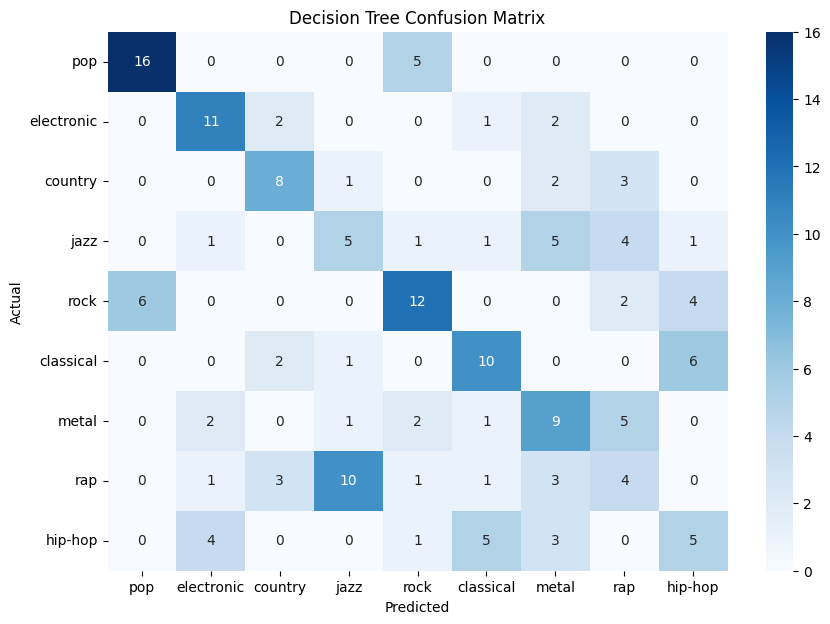

In [7]:
# Define the parameter grid
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 10, 20]
}

# Create a GridSearchCV object
grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='accuracy')

# Fit the model
grid_search_dt.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)
print("Best score for Decision Tree:", grid_search_dt.best_score_)
dtScore = grid_search_dt.best_score_
# Predict on the test set
y_pred_dt = grid_search_dt.best_estimator_.predict(X_test)
dtAccuracy = accuracy_score(y_test, y_pred_dt)
# Evaluate the model
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## K-Nearest Neighbors (KNN)

Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best score for KNN: 0.5739130434782609
KNN Accuracy: 0.5664739884393064
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        21
           1       0.42      0.81      0.55        16
           2       0.71      0.71      0.71        14
           3       0.35      0.33      0.34        18
           4       0.84      0.67      0.74        24
           5       0.56      0.47      0.51        19
           6       0.50      0.55      0.52        20
           7       0.67      0.26      0.38        23
           8       0.39      0.50      0.44        18

    accuracy                           0.57       173
   macro avg       0.59      0.57      0.56       173
weighted avg       0.60      0.57      0.56       173



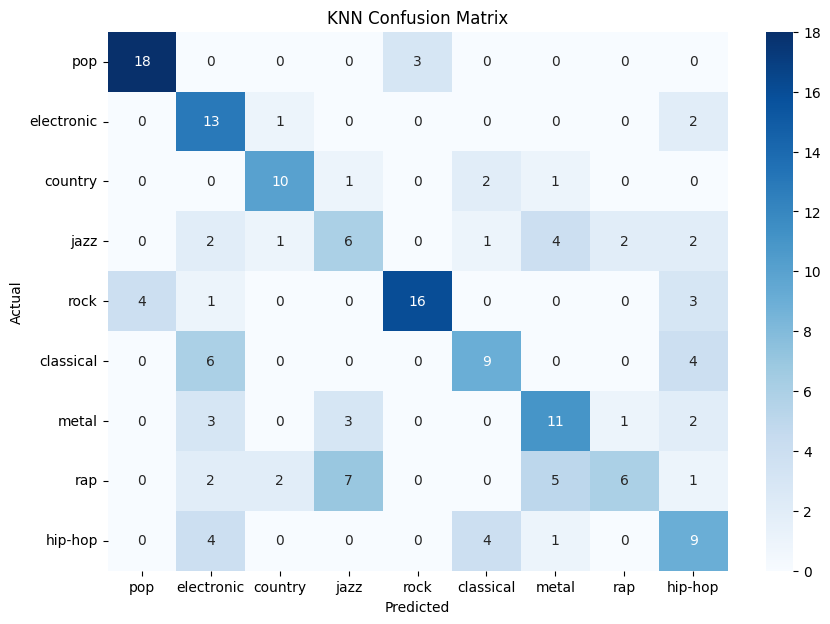

In [8]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create a GridSearchCV object
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')

# Fit the model
grid_search_knn.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters for KNN:", grid_search_knn.best_params_)
print("Best score for KNN:", grid_search_knn.best_score_)

# Predict on the test set
y_pred_knn = grid_search_knn.best_estimator_.predict(X_test)

# Evaluate the model
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualizing results

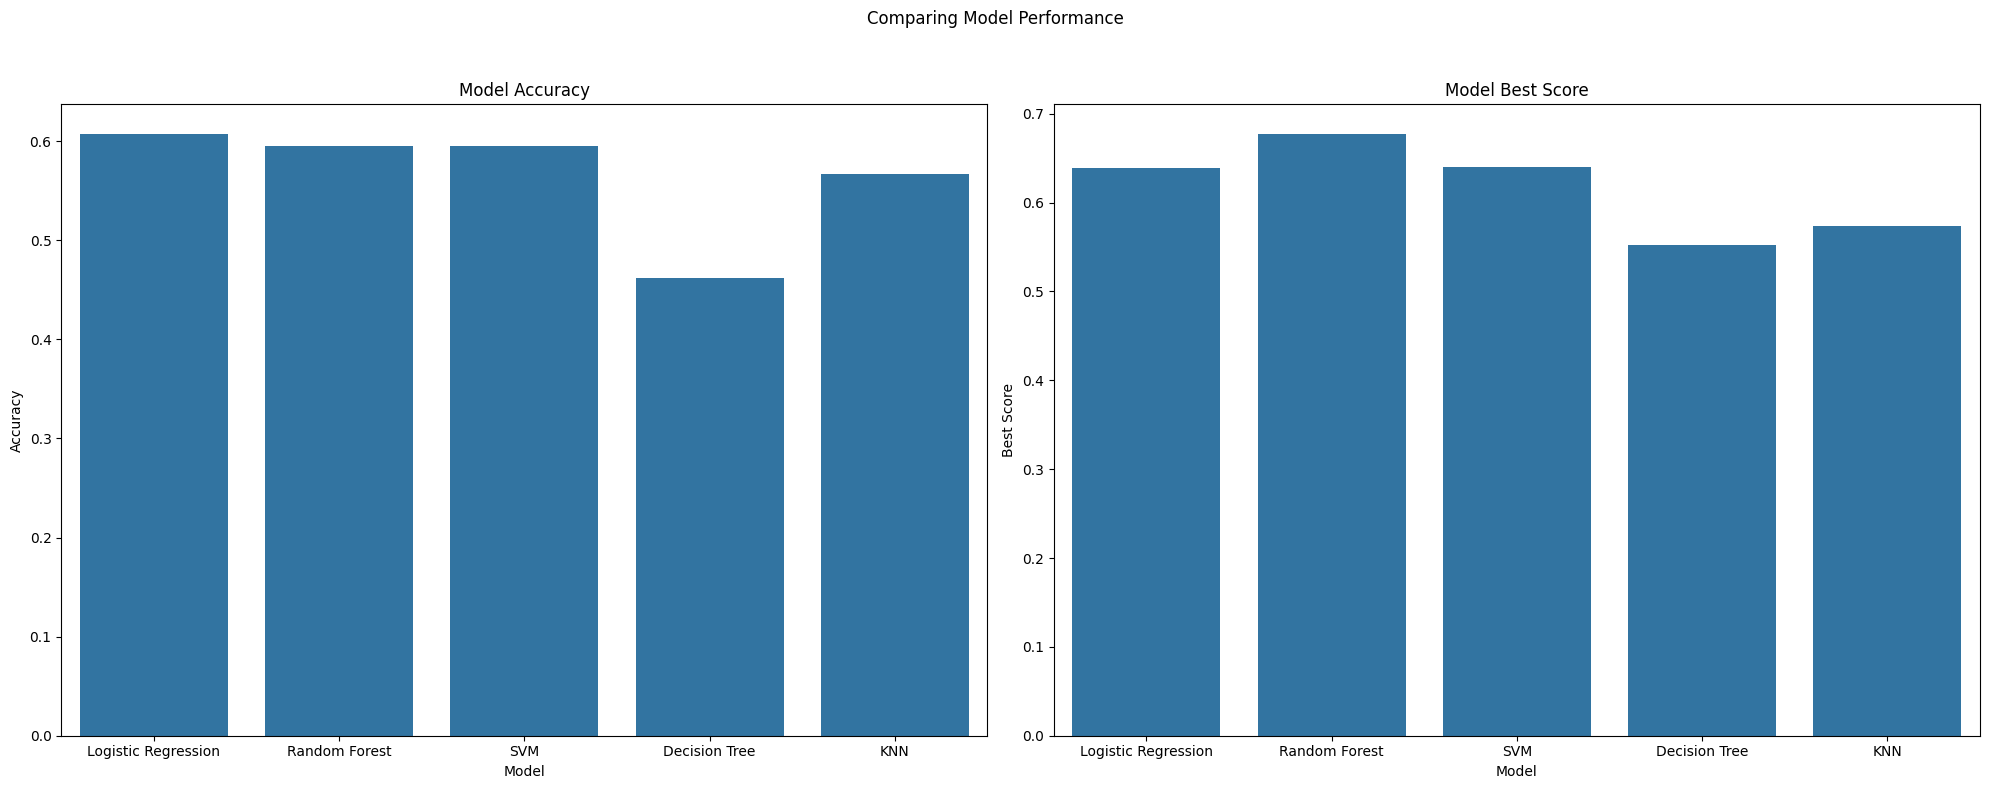

In [9]:
accuracyResults = {
    'Logistic Regression': lrAccuracy,
    'Random Forest': rfAccuracy,
    'SVM': svmAccuracy,
    'Decision Tree': dtAccuracy,
    'KNN': accuracy_score(y_test, y_pred_knn)
}
scoreResults = {
    'Logistic Regression': lrScore,
    'Random Forest': rfScore,
    'SVM': svmScore,
    'Decision Tree': dtScore,
    'KNN': grid_search_knn.best_score_
}
accuracyResults_df = pd.DataFrame.from_dict(accuracyResults, orient='index', columns=['Accuracy'])
scoreResults_df = pd.DataFrame.from_dict(scoreResults, orient='index', columns=['Score'])
accuracyResults_df.sort_values(by='Accuracy', ascending=False)
scoreResults_df.sort_values(by='Score', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(x=accuracyResults_df.index, y='Accuracy', data=accuracyResults_df, ax=axes[0])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Model')

sns.barplot(x=scoreResults_df.index, y='Score', data=scoreResults_df, ax=axes[1])
axes[1].set_title('Model Best Score')
axes[1].set_ylabel('Best Score')
axes[1].set_xlabel('Model')

fig.suptitle('Comparing Model Performance')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# Now let's try and do a neural network using tensorflow

In [15]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

df = pd.read_csv('tracks_data.csv')
print(df.head())

X = df.drop(columns=['genre', 'track_id', 'track_name', 'artist_name'])
y = df['genre']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size = 0.2, random_state = 42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

  genre                track_id                    track_name  artist_name  \
0   pop  3Dv1eDb0MEgF93GpLXlucZ                        Say So     Doja Cat   
1   pop  7MXVkk9YMctZqd1Srtv4MB                       Starboy   The Weeknd   
2   pop  0t3ZvGKlmYmVsDzBJAXK8C   Goodbyes (feat. Young Thug)  Post Malone   
3   pop  7ytR5pFWmSjzHJIeQkgog4  ROCKSTAR (feat. Roddy Ricch)       DaBaby   
4   pop  6DCZcSspjsKoFjzjrWoCdn                    God's Plan        Drake   

     tempo  danceability  energy  acousticness  duration_ms  instrumentalness  \
0  110.962         0.787   0.673        0.2640       237893          0.000003   
1  186.003         0.679   0.587        0.1410       230453          0.000006   
2  150.097         0.547   0.653        0.4560       174853          0.000000   
3   89.977         0.746   0.690        0.2470       181733          0.000000   
4   77.169         0.754   0.449        0.0332       198973          0.000083   

   liveness  loudness  mode  speechiness  ti

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,585 (49.16 KB)

 Trainable params: 12,585 (49.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5942 - loss: 0.9876 - val_accuracy: 0.5278 - val_loss: 1.3205
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6043 - loss: 1.0270 - val_accuracy: 0.5417 - val_loss: 1.3297
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5302 - loss: 1.0531 - val_accuracy: 0.5278 - val_loss: 1.3134
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5688 - loss: 1.0218 - val_accuracy: 0.5764 - val_loss: 1.2836
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5458 - loss: 1.0593 - val_accuracy: 0.5903 - val_loss: 1.2934
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6185 - loss: 0.9582 - val_accuracy: 0.5556 - val_loss: 1.3127
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5867 - loss: 1.0437 - val_accuracy: 0.5764 - val_loss: 1.3173
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5478 - loss: 1.0103 - val_accuracy: 0.5417 - v

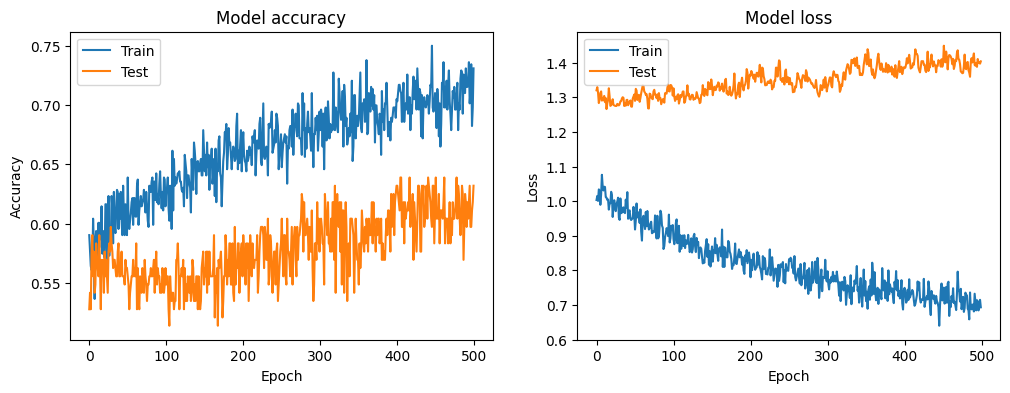

In [17]:
history = model.fit(X_train, y_train, epochs=500, batch_size=50, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [18]:
from sklearn.metrics import classification_report

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1)

# Print the classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

   classical       1.00      0.83      0.90        23
     country       0.69      0.82      0.75        22
  electronic       0.70      0.78      0.74        18
     hip-hop       0.52      0.55      0.53        22
        jazz       0.79      0.94      0.86        16
       metal       0.55      0.50      0.52        22
         pop       0.55      0.48      0.51        25
         rap       0.67      0.53      0.59        19
        rock       0.25      0.31      0.28        13

    accuracy                           0.64       180
   macro avg       0.64      0.64      0.63       180
weighted avg       0.65      0.64      0.64       180

